In [23]:
import pandas as pd
import re
from bert_score import score
import yake
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

pd.set_option('display.max_colwidth', 200)  # Increase column width if needed

In [24]:
df = pd.read_csv('bbc_news_text_complexity_summarization.csv')

# Prepare dataset

In [25]:
def sanitize_text(text):
    text = re.sub('\n', ' ', text)
    return text

df['text'] = df['text'].apply(lambda x: sanitize_text(x))
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,"Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now o...",business,26,62.17,9.72,It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. But its film divisi...,"Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year..."
1,Dollar gains on Greenspan speech The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Al...,business,17,65.56,9.09,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...","""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York..."
2,Yukos unit buyer faces loan claim The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought ...,business,14,69.21,9.66,"The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Legal experts said Rosneft's purchase of Yugansk would include such obligations. Yukos c...
3,"High fuel prices hit BA's profits British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-ta...",business,24,62.98,9.86,"Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...","Rod Eddington, BA's chief executive, said the results were ""respectable"" in a third quarter when fuel costs rose by £106m or 47.3%. BA's profits were still better than market expectation of £59m, ..."
4,Pernod takeover talk lifts Domecq Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wa...,business,17,70.63,10.23,"Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Pernod said it was seeking acquisitions but refused t...


In [26]:
# Define a function to drop similar rows
def drop_similar_rows(df, column, threshold=90):
    to_drop = set()
    for i, text1 in enumerate(df[column]):
        for j, text2 in enumerate(df[column]):
            if i != j and fuzz.ratio(text1, text2) > threshold:
                to_drop.add(j)
    return df.drop(to_drop)

In [27]:
print(f"Before deletion of similar texts {len(df)}")
df = drop_similar_rows(df, 'text', 98)
print(f"After the deletion of similar texts {len(df)}")

Before deletion of similar texts 2127
After the deletion of similar texts 2013


# Extract keywords to enrich the database metadata

In [28]:
language = 'en'
ngram_size = 2
num_of_keywords = 5
deduplication_threshold = 0.2

kw_extractor = yake.KeywordExtractor(lan = language, n = ngram_size, dedupLim = deduplication_threshold, top = num_of_keywords)

def assign_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    keywords_per_row = []
    for kw in keywords:
        keywords_per_row.append(kw[0])
    return keywords_per_row
    
df['keywords'] = df['text'].apply(lambda x:  assign_keywords(x))

# Decide which summary is best and add it to database

In [ ]:
def calculate_bertscore_batch(original_texts, summaries):
    P, R, F1 = score(summaries, original_texts, lang="en", model_type="distilbert-base-uncased", verbose=True)
    return F1.tolist()

# Batch processing
batch_size = 50
F1_scores_text_rank = []
F1_scores_lsa = []
# Determine the better summary

for i in range(0, len(df), batch_size):
    print(i)
    batch = df.iloc[i:i + batch_size]
    F1_scores_text_rank.extend(calculate_bertscore_batch(batch['text'].tolist(), batch['text_rank_summary'].tolist()))
    F1_scores_lsa.extend(calculate_bertscore_batch(batch['text'].tolist(), batch['lsa_summary'].tolist()))

df['BERTScore_TextRank'] = F1_scores_text_rank
df['BERTScore_LSA'] = F1_scores_lsa

In [30]:
def choose_better_summary(row):
    if row['BERTScore_TextRank'] > row['BERTScore_LSA']:
        return 'TextRank'
    elif row['BERTScore_LSA'] > row['BERTScore_TextRank']:
        return 'LSA'
    else:
        return 'Tie'
        
df['Better_Summary'] = df.apply(choose_better_summary, axis=1)

df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary,keywords,BERTScore_TextRank,BERTScore_LSA,Better_Summary
0,"Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now o...",business,26,62.17,9.72,It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. But its film divisi...,"Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year...","[Time Warner, Quarterly profits, AOL, media giant, sales]",0.821837,0.837592,LSA
1,Dollar gains on Greenspan speech The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Al...,business,17,65.56,9.09,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...","""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York...","[Federal Reserve, Greenspan speech, highest level, Dollar, deficit]",0.852073,0.851272,TextRank
2,Yukos unit buyer faces loan claim The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought ...,business,14,69.21,9.66,"The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Legal experts said Rosneft's purchase of Yugansk would include such obligations. Yukos c...,"[embattled Russian, Russian oil, unit buyer, Yukos, pay back]",0.882569,0.864083,TextRank
3,"High fuel prices hit BA's profits British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-ta...",business,24,62.98,9.86,"Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...","Rod Eddington, BA's chief executive, said the results were ""respectable"" in a third quarter when fuel costs rose by £106m or 47.3%. BA's profits were still better than market expectation of £59m, ...","[British Airways, High fuel, blamed high, fuel prices, profits]",0.852375,0.837522,TextRank
4,Pernod takeover talk lifts Domecq Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wa...,business,17,70.63,10.23,"Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Pernod said it was seeking acquisitions but refused t...,"[Allied Domecq, Domecq Shares, Pernod Ricard, talk lifts, France]",0.857367,0.834634,TextRank


In [31]:
df['Better_Summary'].value_counts()

Better_Summary
TextRank    1570
LSA          441
Tie            2
Name: count, dtype: int64

In [32]:
df['summary'] = df.apply(
    lambda row: row['lsa_summary'] if row['Better_Summary'] == 'LSA' else row['text_rank_summary'], 
    axis=1
)
df = df.drop(columns = ['lsa_summary', 'text_rank_summary', 'BERTScore_TextRank', 'BERTScore_LSA', 'Better_Summary'])

# Make model to classify categories

<Axes: xlabel='labels', ylabel='count'>

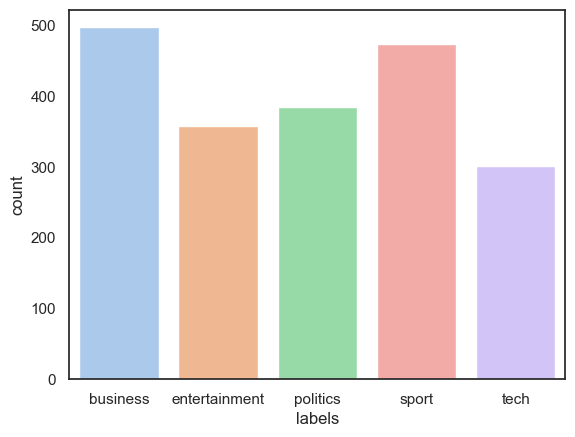

In [33]:
sns.set_theme(style="white", palette="pastel")
sns.countplot(x="labels", hue = "labels", data=df)

In [34]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['labels'])

In [74]:
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,keywords,summary,category_encoded
0,"Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now o...",business,26,62.17,9.72,"[Time Warner, Quarterly profits, AOL, media giant, sales]","Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year...",0
1,Dollar gains on Greenspan speech The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Al...,business,17,65.56,9.09,"[Federal Reserve, Greenspan speech, highest level, Dollar, deficit]","The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...",0
2,Yukos unit buyer faces loan claim The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought ...,business,14,69.21,9.66,"[embattled Russian, Russian oil, unit buyer, Yukos, pay back]","The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",0
3,"High fuel prices hit BA's profits British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-ta...",business,24,62.98,9.86,"[British Airways, High fuel, blamed high, fuel prices, profits]","Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...",0
4,Pernod takeover talk lifts Domecq Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wa...,business,17,70.63,10.23,"[Allied Domecq, Domecq Shares, Pernod Ricard, talk lifts, France]","Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",0


In [75]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['category_encoded'],
                                                    test_size=0.2,
                                                    random_state=0, 
                                                    stratify = df['category_encoded']
                                                    )

In [76]:
vectorizer = TfidfVectorizer(stop_words='english',
                             ngram_range=(1,3),
                             min_df=5,
                             strip_accents='unicode')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 229747 stored elements and shape (1610, 10681)>

In [77]:
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True values')
    plt.xlabel('Received values')
    plt.tight_layout()

              precision    recall  f1-score   support

           0     0.9412    0.9600    0.9505       100
           1     1.0000    0.9859    0.9929        71
           2     0.9737    0.9610    0.9673        77
           3     0.9896    1.0000    0.9948        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9727       403
   macro avg     0.9741    0.9714    0.9727       403
weighted avg     0.9729    0.9727    0.9727       403



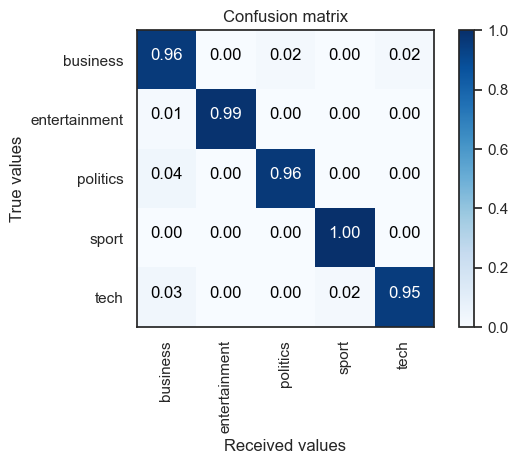

In [78]:
# Train a multi-output classifier
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = clf.predict(X_test_vectorized)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, label_encoder.classes_)

              precision    recall  f1-score   support

           0     0.9490    0.9300    0.9394       100
           1     1.0000    0.9859    0.9929        71
           2     0.9494    0.9740    0.9615        77
           3     0.9794    1.0000    0.9896        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9677       403
   macro avg     0.9688    0.9680    0.9683       403
weighted avg     0.9678    0.9677    0.9677       403



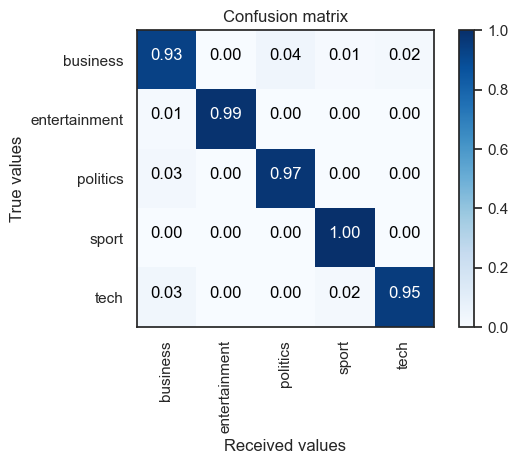

In [79]:
from sklearn.linear_model import LogisticRegression

clf_2 = LogisticRegression(max_iter=1000)
clf_2.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = clf_2.predict(X_test_vectorized)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, label_encoder.classes_)

              precision    recall  f1-score   support

           0     0.9588    0.9300    0.9442       100
           1     1.0000    0.9718    0.9857        71
           2     0.9500    0.9870    0.9682        77
           3     0.9896    1.0000    0.9948        95
           4     0.9508    0.9667    0.9587        60

    accuracy                         0.9702       403
   macro avg     0.9698    0.9711    0.9703       403
weighted avg     0.9704    0.9702    0.9702       403



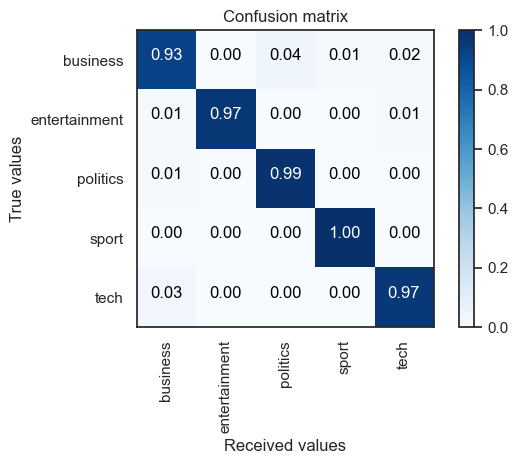

In [80]:
from sklearn.svm import LinearSVC

clf_3 = LinearSVC()
clf_3.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = clf_3.predict(X_test_vectorized)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, label_encoder.classes_)

              precision    recall  f1-score   support

           0     0.9796    0.9600    0.9697       100
           1     0.9861    1.0000    0.9930        71
           2     0.9620    0.9870    0.9744        77
           3     0.9500    1.0000    0.9744        95
           4     1.0000    0.9000    0.9474        60

    accuracy                         0.9727       403
   macro avg     0.9755    0.9694    0.9718       403
weighted avg     0.9734    0.9727    0.9725       403



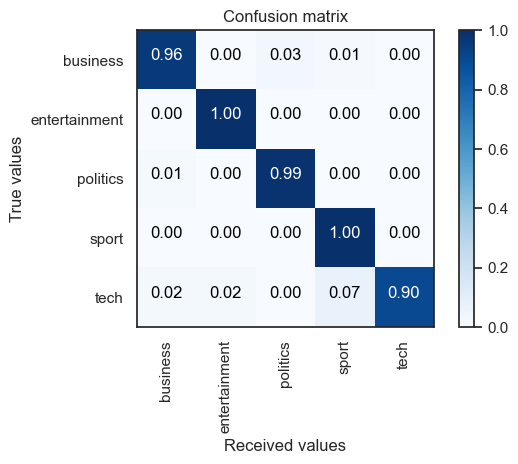

In [81]:
from sklearn.ensemble import RandomForestClassifier
clf_4 = RandomForestClassifier()
clf_4.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = clf_4.predict(X_test_vectorized)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, label_encoder.classes_)

# Save models

In [82]:
import pickle

In [83]:
with open('BBC_articles_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

with open('BBC_articles_classifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

with open('BBC_articles_label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Sources

1. https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset
2. https://github.com/Jannixen/Azure-Depression-from-tweets/blob/main/notebooks/depression_detection.ipynb